# House Price Prediction

# Import Libraries 

In [39]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load the dataset 

In [40]:
file_path =r'C:\Users\DELL\Desktop\data.csv'
data = pd.read_csv(file_path)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,02/05/2014 00:00,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,02/05/2014 00:00,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,02/05/2014 00:00,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,02/05/2014 00:00,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,02/05/2014 00:00,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


# Data Cleaning 

In [41]:
# Check for missing values
missing_values = data.isnull()
# Print the number of missing values in each column
print(missing_values.sum())

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64


In [42]:
# Identify categorical and numerical columns
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))
# Print all column names to identify the features
print("All columns:", data.columns)

Categorical variables: 5
Integer variables: 10
Float variables: 3
All columns: Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')


In [43]:
#Visualization
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])
numeric_features = num_cols + fl_cols
print ( "numeric features are:", numeric_features)


numeric features are: ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'price', 'bathrooms', 'floors']


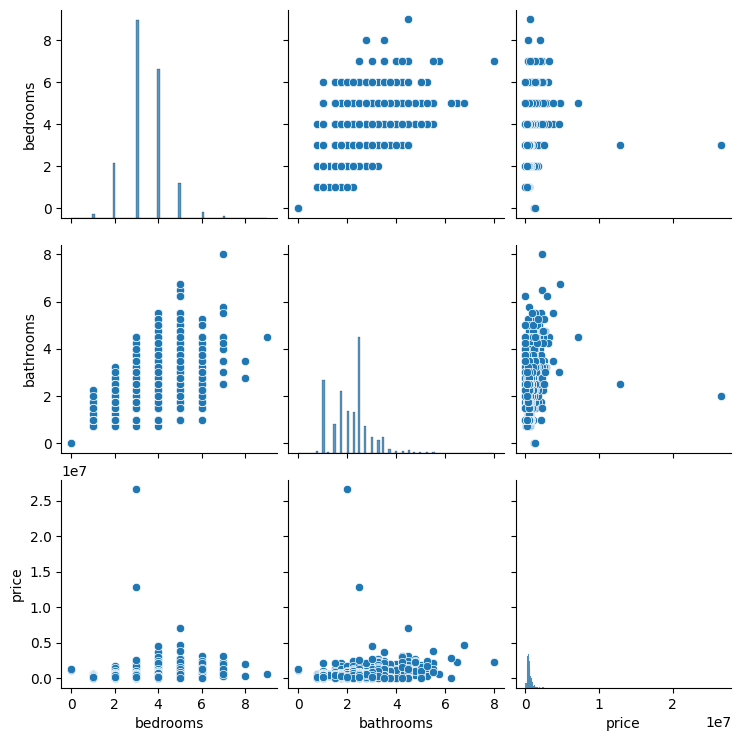

In [53]:
# Pairplot for all numeric features
sns.pairplot(data, vars=numeric_features + ['price'])
plt.show()

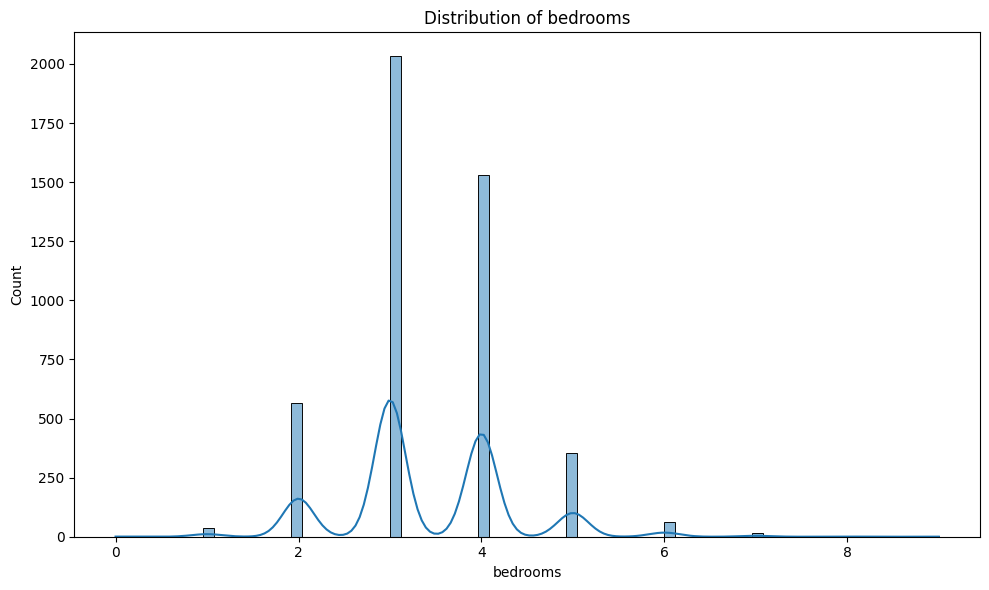

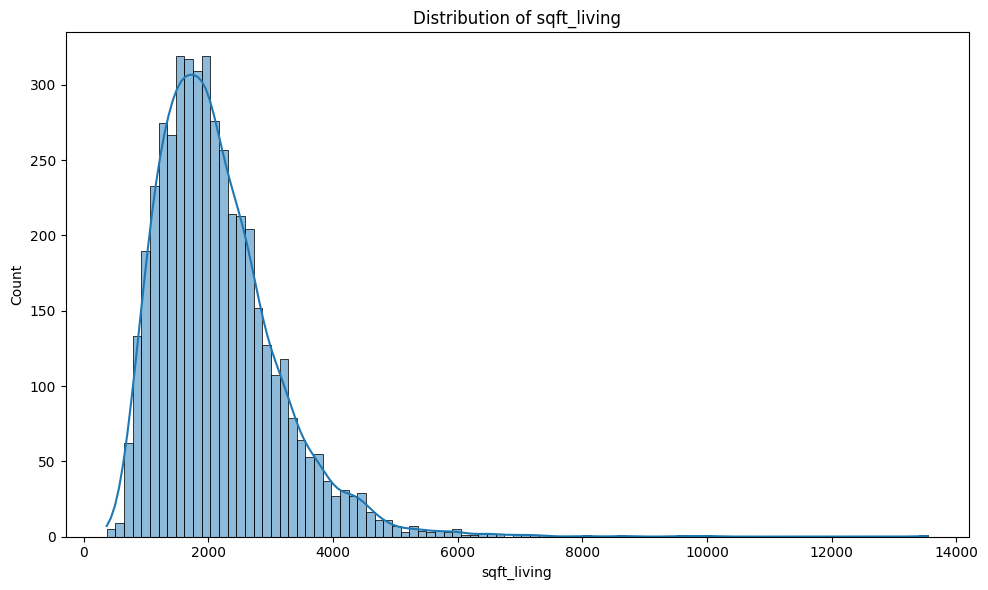

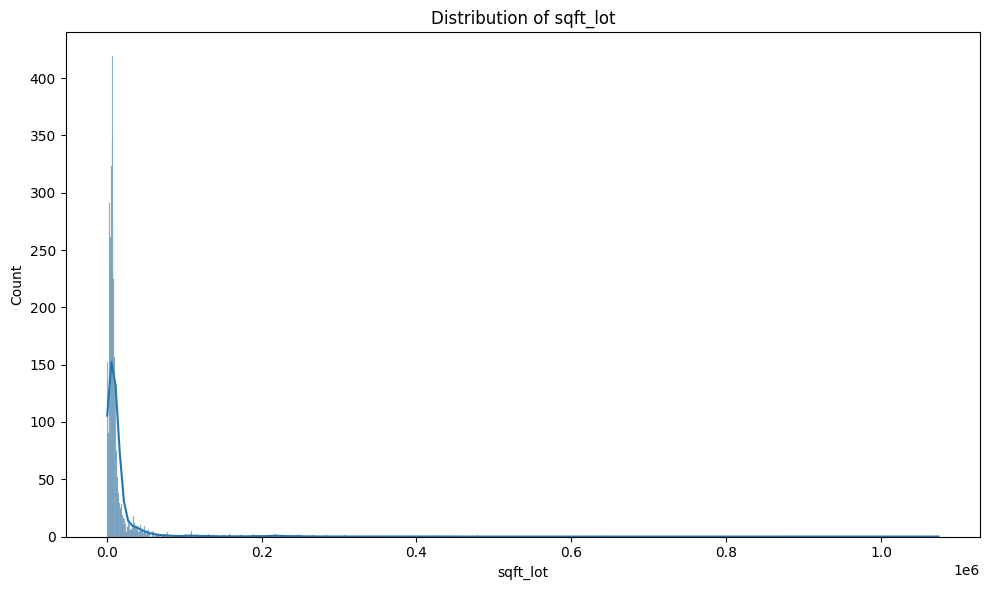

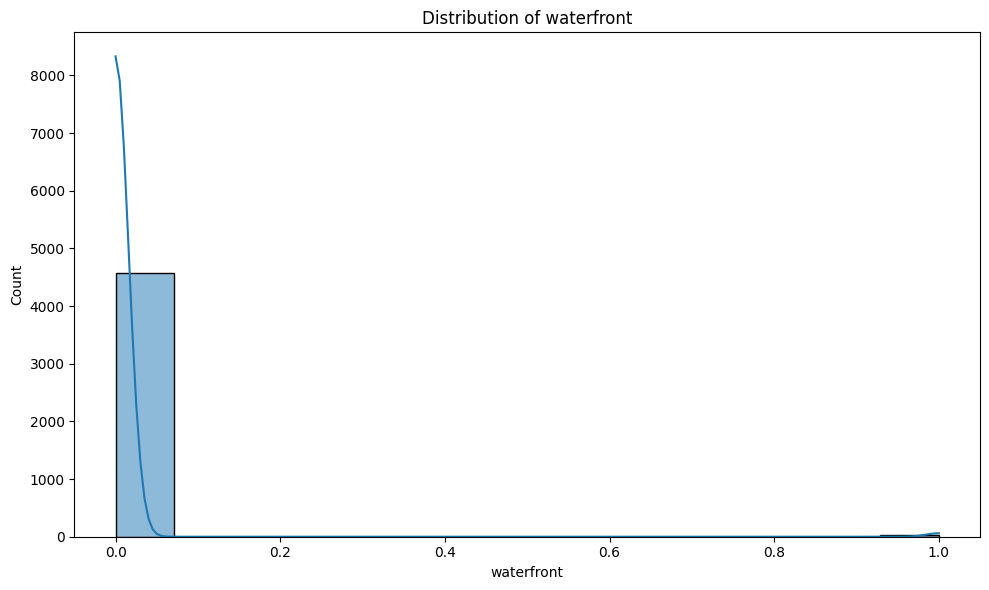

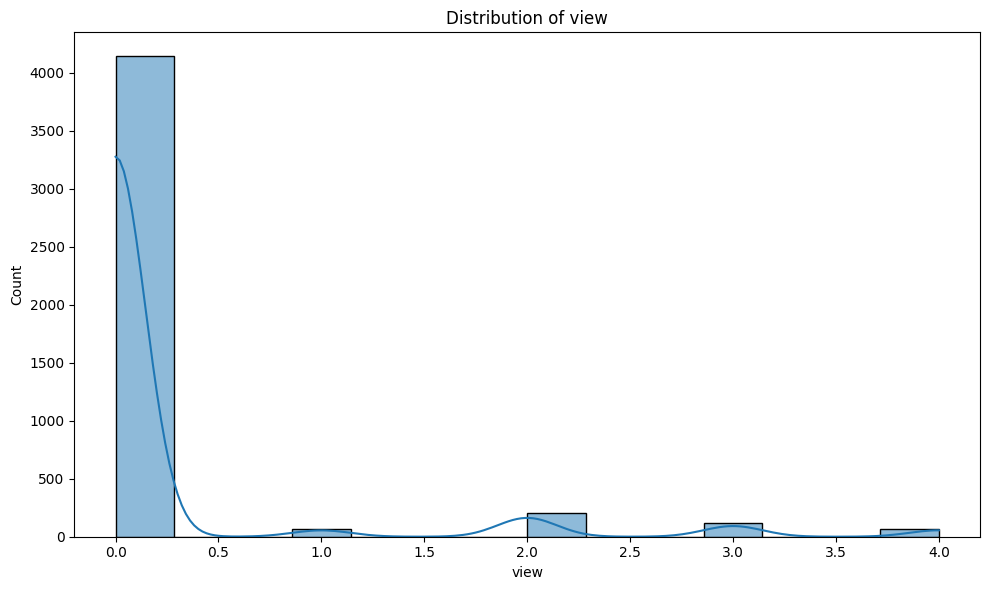

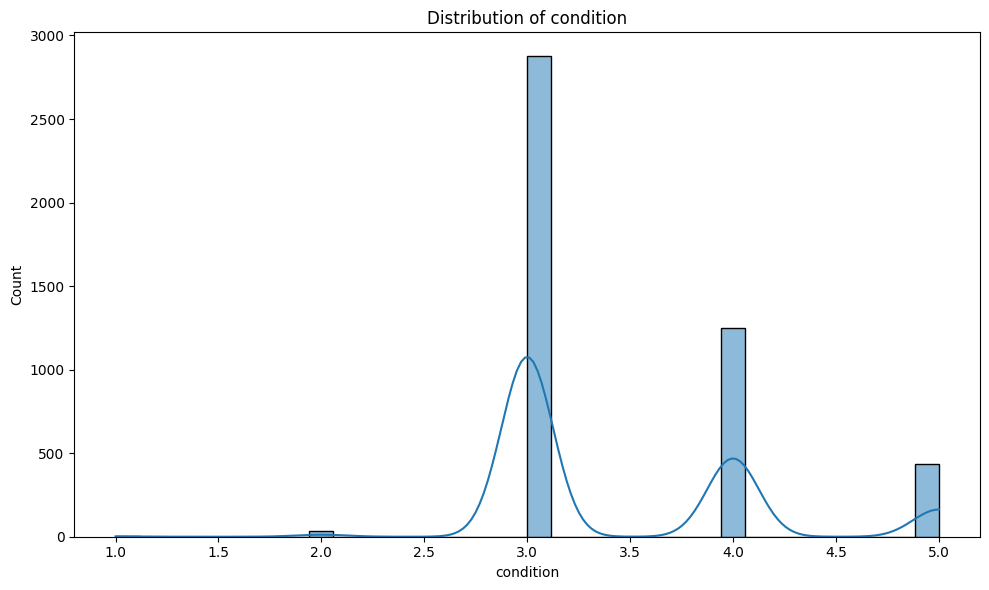

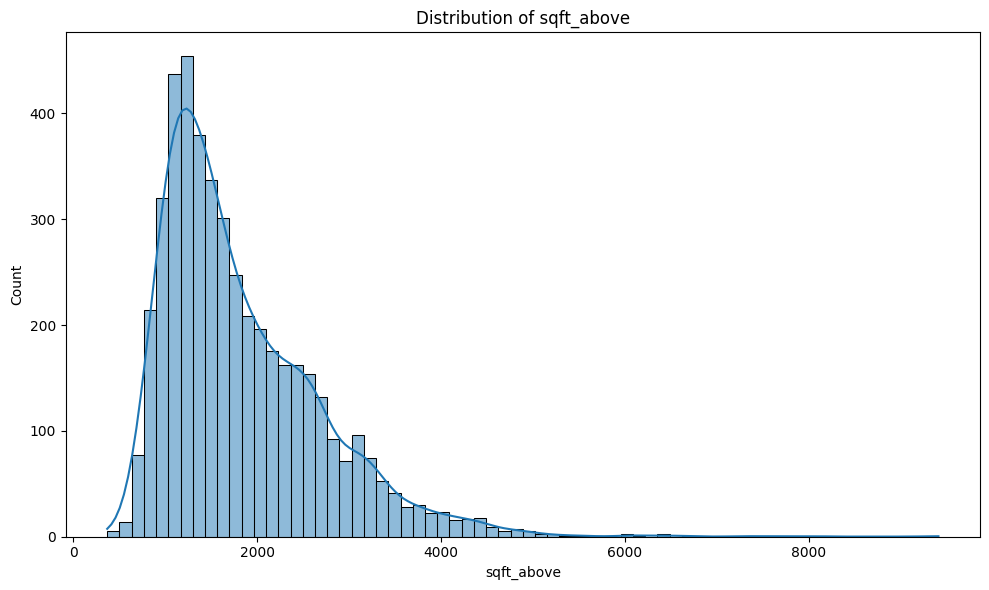

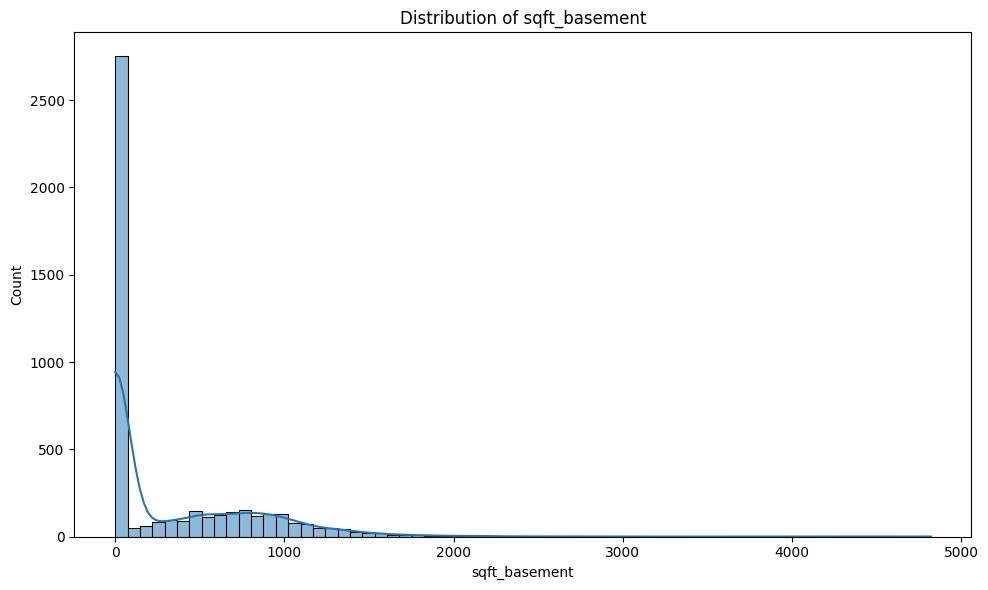

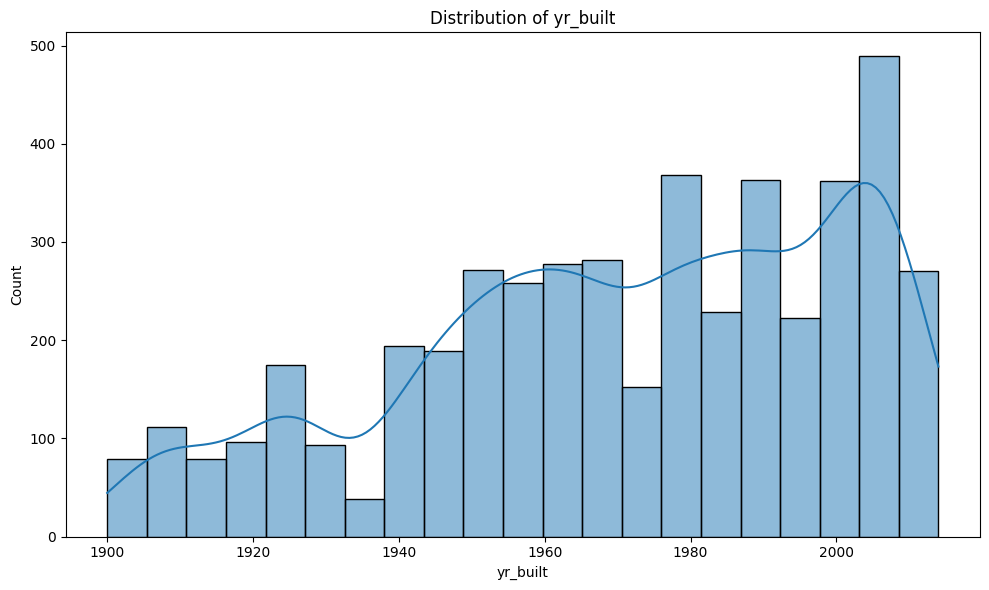

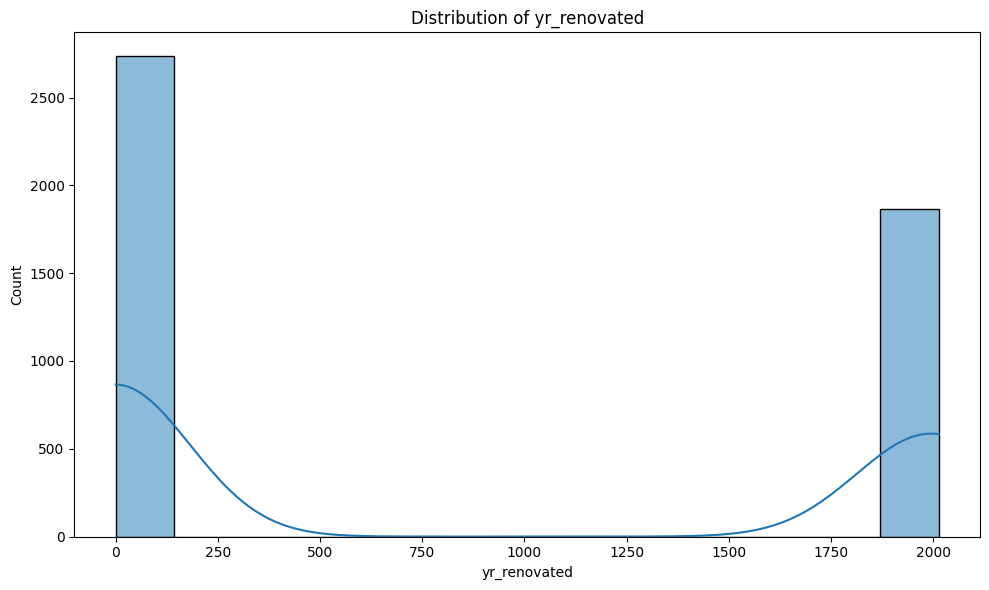

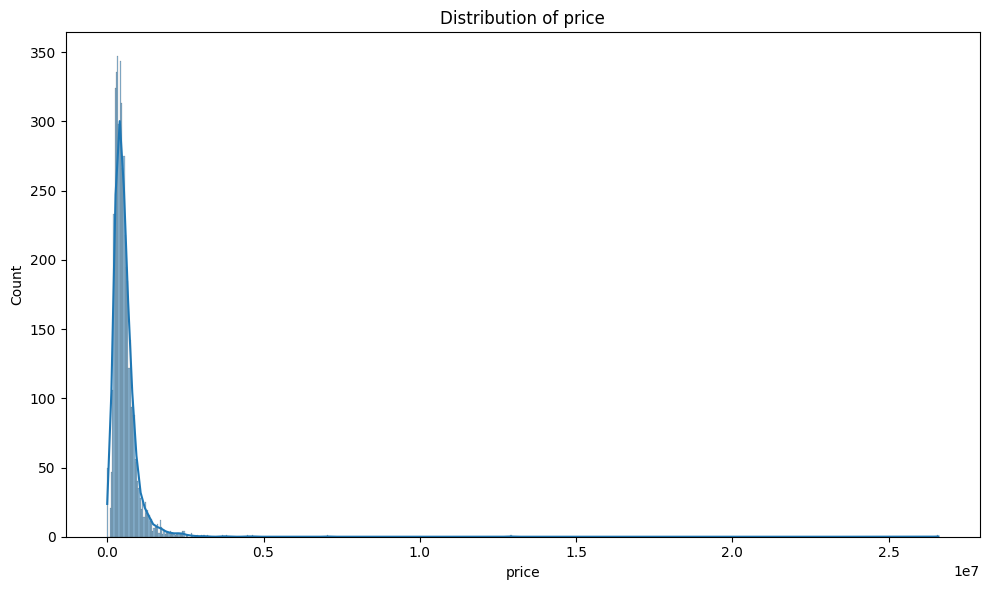

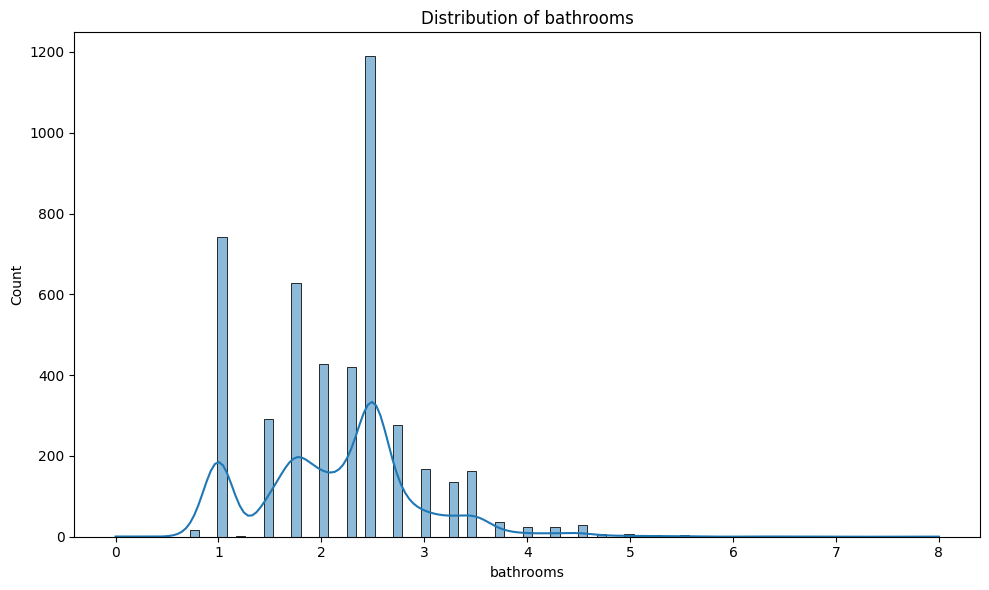

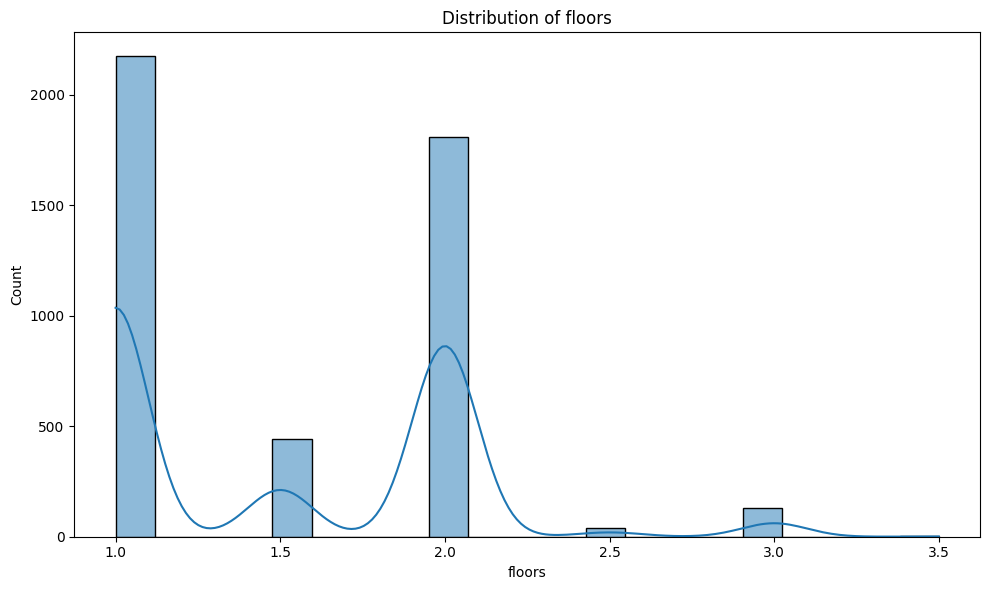

In [45]:
# Distribution plots for numeric features
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()


# Feature engineering

In [46]:
# Features and target
X = data.drop('price', axis=1)
y = data['price']

In [47]:
# Define which columns are numerical and categorical
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
# Preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [48]:
# Preprocessing and feature engineering
X_processed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3680, 4729)
X_test shape: (920, 4729)
y_train shape: (3680,)
y_test shape: (920,)


# Model Building with Scikit-learn

In [49]:
# Initialize the Linear Regression model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate Mean Squared Error
mse_skl = mean_squared_error(y_test, y_pred)
# Calculate R-squared
r2_skl = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_skl)
print("R-squared:", r2_skl)


Mean Squared Error: 1151905210288.12
R-squared: -0.1294889877135741


# Model Building with TensorFlow

In [50]:
#define the model architecture
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])
#complire the model
tf_model.compile(optimizer='adam',
              loss='mse',  # Mean Squared Error loss function for regression
              metrics=['mae'])  # Mean Absolute Error as a metric
#evaluate the model
loss, mae = tf_model.evaluate(X_test, y_test)
print("Mean Squared Error:", loss)
print("Mean Absolute Error:", mae)

# Make predictions on the test set using the TensorFlow model
y_pred_tf = tf_model.predict(X_test)

mse_tf = mean_squared_error(y_test, y_pred_tf)  # Calculate Mean Squared Error

r2_tf = r2_score(y_test, y_pred_tf)  # Calculate R-squared

print("\nTensorFlow Model Metrics:")
print("Mean Squared Error:", mse_tf)
print("R-squared:", r2_tf)


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 585333276672.0000 - mae: 565572.8125
Mean Squared Error: 1356735971328.0
Mean Absolute Error: 580422.0
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

TensorFlow Model Metrics:
Mean Squared Error: 1356736003250.0098
R-squared: -0.33033374727258846


# Model Comparison and Selection 

In [51]:
if mse_skl < mse_tf:
    print("\nScikit-learn Linear Regression model performs better (lower MSE).")
else:
    print("\nTensorFlow Neural Network model performs better (lower MSE).")

if r2_skl > r2_tf:
    print("Scikit-learn Linear Regression model performs better (higher R-squared).")
else:
    print("TensorFlow Neural Network model performs better (higher R-squared).")



Scikit-learn Linear Regression model performs better (lower MSE).
Scikit-learn Linear Regression model performs better (higher R-squared).


# Model Saving

In [52]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with columns ['bedrooms', 'bathrooms', 'city', 'price']
X = data[['bedrooms', 'bathrooms', 'city']]
y = data['price']

# Preprocessor for numerical and categorical features
numeric_features = ['bedrooms', 'bathrooms']
categorical_features = ['city']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model
model.fit(X, y)

# Save the model
joblib.dump(model, 'LR_model.pkl')


['LR_model.pkl']